In [236]:
!pip install statsmodels==0.13.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Variable 

from sklearn import preprocessing
from statsmodels.tsa.arima.model import ARIMA

## Loading data

In [238]:
def csv_preprocessing_local():
    data_1 = pd.read_csv('ods001.csv', sep = ';')
    data_2 = pd.read_csv('ods034.csv', sep = ';')
    data_3 = pd.read_csv('ods035.csv', sep = ';')

    data_1.rename({'DateTime' : 'Datetime'}, axis = 1, inplace=True)
    data_2.rename({'Fuel code' : 'Fuel'}, axis = 1, inplace=True)

    result_data = pd.merge(data_2, data_3, on = ['Datetime', 'Fuel'])
    result_data = pd.merge(data_1, result_data, on = 'Datetime')
    result_data.Datetime = pd.to_datetime(result_data.Datetime)
    result_data.drop(['Resolution code', 'Resolution code_x', 'Resolution code_y'], axis = 1, inplace = True)
    result_data['Datetime'] = pd.to_datetime(result_data['Datetime'], utc=True)
    result_data.set_index('Datetime', inplace=True)

    f = open("input_data.csv", "w")

    result_data.to_csv('input_data.csv')

In [239]:
def data_loading_old():    
    url_dict = {}
    for year in range (2015, 2022):
        url_dict.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/day_ahead_prices_{year}.csv'})

    train_data = pd.DataFrame([])

    for _, url in list(url_dict.items())[:-2]:
        train_data = pd.concat([train_data, pd.read_csv(url)]) if len(train_data) else pd.read_csv(url)

    test_data = pd.read_csv(url_dict['url_2020'])

    train_data['Datetime'] = pd.to_datetime(train_data['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data['Datetime'] = pd.to_datetime(test_data['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data.drop(['MTU (CET)'], axis = 1, inplace= True)
    test_data.drop(['MTU (CET)'], axis = 1, inplace= True)
    #train_data.set_index('Datetime', inplace= True)

    exogeneous_data = pd.read_csv('https://raw.githubusercontent.com/ishilov/DL-DIY/master/input_data.csv')
    date = pd.to_datetime('01.01.2020')

    date_2 = pd.to_datetime('01.01.2021')
    
    exogeneous_data['Datetime'] = pd.to_datetime(exogeneous_data['Datetime'])

    exogeneous_data.Datetime = exogeneous_data.Datetime.dt.tz_localize(None)
    train_data.Datetime = train_data.Datetime.dt.tz_localize(None)
    test_data.Datetime = test_data.Datetime.dt.tz_localize(None)

    exogeneous_train = exogeneous_data[exogeneous_data.Datetime < date]
    exogeneous_test = exogeneous_data[exogeneous_data.Datetime >= date]
    exogeneous_test = exogeneous_test[exogeneous_test.Datetime < date_2]

    #exogeneous_data.set_index('Datetime', inplace= True)

    train_data = pd.merge(exogeneous_train, train_data, on = 'Datetime')
    test_data = pd.merge(exogeneous_test, test_data, on = 'Datetime')

    return train_data, test_data

In [240]:
def data_loading():
    train_data_be_prices, test_data_be_prices = pd.DataFrame([]), pd.DataFrame([])
    train_data_fr_prices, test_data_fr_prices = pd.DataFrame([]), pd.DataFrame([])
    train_data_be_load, test_data_be_load = pd.DataFrame([]), pd.DataFrame([])
    train_data_be_generation, test_data_be_generation = pd.DataFrame([]), pd.DataFrame([])

    #first we load all the data from the github

    url_dict_be_prices, url_dict_fr_prices, url_dict_be_load, url_dict_be_generation  = {}, {}, {}, {}
    for year in range (2015, 2022):
        url_dict_be_prices.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/day_ahead_prices_{year}.csv'})
        url_dict_fr_prices.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/france_prices/Day_ahead_Prices_{year}_france.csv'})
        url_dict_be_load.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/load_data_belgium/Total%20Load_Day%20Ahead_%20Actual_{year}.csv'})
        url_dict_be_generation.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/actual_generation_belgium/Actual_Generation_per_Production_Type_{year}.csv'})

    #for the training dataset we take 2015-2019 (or 2020) and for the test 2020 (or 2021)
    #take the belgian prices
    for _, url in list(url_dict_be_prices.items())[:-2]:
        train_data_be_prices = pd.concat([train_data_be_prices, pd.read_csv(url)], ignore_index=True) if len(train_data_be_prices) else pd.read_csv(url)

    test_data_be_prices = pd.read_csv(url_dict_be_prices['url_2020'])

    train_data_be_prices['Datetime'] = pd.to_datetime(train_data_be_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_be_prices['Datetime'] = pd.to_datetime(test_data_be_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_be_prices.drop(['MTU (CET)'], axis = 1, inplace= True)
    test_data_be_prices.drop(['MTU (CET)'], axis = 1, inplace= True)

    train_data_be_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices Belgium'}, axis = 1, inplace = True)
    test_data_be_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices Belgium'}, axis = 1, inplace = True)

    #take the france prices
    for _, url in list(url_dict_fr_prices.items())[:-2]:
        train_data_fr_prices = pd.concat([train_data_fr_prices, pd.read_csv(url)], ignore_index=True) if len(train_data_fr_prices) else pd.read_csv(url)

    test_data_fr_prices = pd.read_csv(url_dict_fr_prices['url_2020'])

    train_data_fr_prices['Datetime'] = pd.to_datetime(train_data_fr_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_fr_prices['Datetime'] = pd.to_datetime(test_data_fr_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_fr_prices.drop(['MTU (CET)'], axis = 1, inplace= True)
    test_data_fr_prices.drop(['MTU (CET)'], axis = 1, inplace= True)

    train_data_fr_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices France'}, axis = 1, inplace = True)
    test_data_fr_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices France'}, axis = 1, inplace = True)

    #take belgian load
    for _, url in list(url_dict_be_load.items())[:-2]:
        train_data_be_load = pd.concat([train_data_be_load, pd.read_csv(url)], ignore_index=True) if len(train_data_be_load) else pd.read_csv(url)

    test_data_be_load = pd.read_csv(url_dict_be_load['url_2020'])

    train_data_be_load['Datetime'] = pd.to_datetime(train_data_be_load['Time (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_be_load['Datetime'] = pd.to_datetime(test_data_be_load['Time (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_be_load.drop(['Time (CET)'], axis = 1, inplace= True)
    test_data_be_load.drop(['Time (CET)'], axis = 1, inplace= True)

    #take_belgian_generation
    for _, url in list(url_dict_be_generation.items())[:-2]:
        train_data_be_generation = pd.concat([train_data_be_generation, pd.read_csv(url)], ignore_index=True) if len(train_data_be_generation) else pd.read_csv(url)

    test_data_be_generation = pd.read_csv(url_dict_be_generation['url_2020'])  

    train_data_be_generation['Datetime'] = pd.to_datetime(train_data_be_generation['MTU'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_be_generation['Datetime'] = pd.to_datetime(test_data_be_generation['MTU'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_be_generation.drop(['MTU'], axis = 1, inplace= True)
    test_data_be_generation.drop(['MTU'], axis = 1, inplace= True)

    #aggregating the load

    train_data_be_load = train_data_be_load.groupby(train_data_be_load.index // 4).sum().reset_index()
    train_data_be_load['Datetime'] = train_data_be_generation.Datetime

    test_data_be_load = test_data_be_load.groupby(test_data_be_load.index // 4).sum().reset_index()
    test_data_be_load['Datetime'] = test_data_be_generation.Datetime

    result_train = pd.merge(train_data_fr_prices, train_data_be_prices, on='Datetime')
    result_train = pd.merge(result_train, train_data_be_generation, on = 'Datetime')
    result_train = pd.merge(result_train, train_data_be_load, on = 'Datetime')

    result_test = pd.merge(test_data_fr_prices, test_data_be_prices, on='Datetime')
    result_test = pd.merge(result_test, test_data_be_generation, on = 'Datetime')
    result_test = pd.merge(result_test, test_data_be_load, on = 'Datetime')

    #last changes 
    result_train.drop(['BZN|FR', 'Area'], axis = 1, inplace = True)
    result_test.drop(['BZN|FR', 'Area'], axis = 1, inplace = True)

    empty_cols = ['Fossil Brown coal/Lignite  - Actual Aggregated [MW]', 'Fossil Coal-derived gas  - Actual Aggregated [MW]', 
                'Fossil Oil shale  - Actual Aggregated [MW]', 'Fossil Peat  - Actual Aggregated [MW]', 'Geothermal  - Actual Aggregated [MW]', 
                'Hydro Water Reservoir  - Actual Aggregated [MW]', 'Marine  - Actual Aggregated [MW]', 'Other renewable  - Actual Aggregated [MW]']

    result_train.drop(empty_cols, axis = 1, inplace = True)
    result_test.drop(empty_cols, axis = 1, inplace = True)

    #result_train.dropna(axis=0, inplace = True)
    #result_test.dropna(axis=0, inplace = True)

    cols = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE']

    result_train.fillna(method='bfill', axis = 0, inplace = True)
    result_test.fillna(method='bfill', axis = 0, inplace = True)

    #result_train.dropna(axis=0, inplace = True)
    #result_test.dropna(axis=0, inplace = True)

    result_train.replace('n/e', 0, inplace = True)
    result_test.replace('n/e', 0, inplace = True)

    return result_train, result_test

In [241]:
train_data, test_data = data_loading()

In [242]:
test_data

,Prices France,Datetime,Prices Belgium,Biomass - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],index,Day-ahead Total Load Forecast [MW] - CTA|BE,Actual Total Load [MW] - CTA|BE
0,41.88,2020-01-01 00:00:00+00:00,41.88,358.0,1749.0,0,0.0,49.0,103.0,31.0,4130.0,678.0,0.0,241.0,407.0,361.0,0,36430.0,36276.0
1,38.60,2020-01-01 01:00:00+00:00,38.60,359.0,1694.0,0,0.0,49.0,168.0,31.0,4128.0,608.0,0.0,243.0,448.0,296.0,1,34176.0,34802.0
2,36.55,2020-01-01 02:00:00+00:00,36.55,357.0,1629.0,0,0.0,49.0,21.0,32.0,4128.0,609.0,0.0,242.0,356.0,197.0,2,32743.0,33281.0
3,32.32,2020-01-01 03:00:00+00:00,32.32,352.0,1678.0,0,0.0,49.0,10.0,32.0,4128.0,626.0,0.0,241.0,271.0,191.0,3,31587.0,32003.0
4,30.85,2020-01-01 04:00:00+00:00,30.85,353.0,1705.0,0,0.0,49.0,12.0,32.0,4130.0,630.0,0.0,243.0,180.0,168.0,4,30882.0,31182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794,60.54,2020-12-31 19:00:00+00:00,61.51,297.0,2487.0,0,0.0,779.0,108.0,39.0,4990.0,788.0,0.0,237.0,145.0,34.0,8780,41715.0,40976.0
8795,56.75,2020-12-31 20:00:00+00:00,56.79,298.0,2380.0,0,0.0,508.0,108.0,39.0,4989.0,809.0,0.0,236.0,183.0,32.0,8781,39513.0,39178.0
8796,52.44,2020-12-31 21:00:00+00:00,52.44,302.0,2451.0,0,0.0,182.0,108.0,39.0,4988.0,809.0,0.0,232.0,203.0,32.0,8782,37901.0,37545.0
8797,51.86,2020-12-31 22:00:00+00:00,51.86,299.0,2357.0,0,0.0,NaN,108.0,39.0,4989.0,732.0,0.0,233.0,234.0,26.0,8783,38571.0,38328.0


In [243]:
train_data.columns

Index(['Prices France', 'Datetime', 'Prices Belgium',
       'Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'index',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE'],
      dtype='object')

In [244]:
def data_normalization(df, add_timestamp = False, test = False):
    transformer = preprocessing.MaxAbsScaler()
    cols = ['Prices France', 'Prices Belgium',
       'Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE']
    transformed_data = transformer.fit_transform(train_data[cols])

    df_normalized = pd.DataFrame(transformed_data)
    df_normalized.columns = cols
    df_normalized.dropna(axis = 0, inplace = True)

    df_normalized.reset_index(inplace = True)

    df_normalized['Datetime'] = df['Datetime']

    #train_data_normalized.set_index('Datetime', inplace = True)

    return df_normalized

In [245]:
def encoding_datetime(df, save_datetime = False):
    df['year'] = df.Datetime.dt.year

    df['hr_sin'] = np.sin(df.Datetime.dt.hour*(2.*np.pi/24))
    df['hr_cos'] = np.cos(df.Datetime.dt.hour*(2.*np.pi/24))
    df['day_sin'] = np.sin((df.Datetime.dt.day-1)*(2.*np.pi/7))
    df['day_cos'] = np.cos((df.Datetime.dt.day-1)*(2.*np.pi/7))
    df['mnth_sin'] = np.sin((df.Datetime.dt.month-1)*(2.*np.pi/12))
    df['mnth_cos'] = np.cos((df.Datetime.dt.month-1)*(2.*np.pi/12))

    if not save_datetime:
        df.drop(['Datetime'], axis = 1, inplace = True)

    return df

In [246]:
def target_column_as_list(df):
    target_list = []
    features_list = []

    col = 'Prices Belgium'

    for value in df[col]:
        target_list.append(torch.tensor(value))

    if 'Datetime' in df.columns:
        df.drop('Datetime', axis =1, inplace = true)

    for index, row in df.loc[:, df.columns != col].iterrows():
        features_list.append(torch.from_numpy(row.values))

    return target_list, features_list

In [247]:
test_data.columns

Index(['Prices France', 'Datetime', 'Prices Belgium',
       'Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'index',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE'],
      dtype='object')

<AxesSubplot:xlabel='Datetime', ylabel='Prices Belgium'>

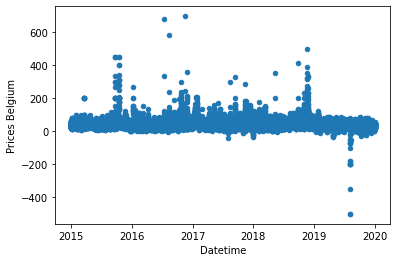

In [248]:
cols = ['Datetime', 'Prices Belgium']
plot_price = train_data[cols].drop_duplicates()
plot_price.plot.scatter('Datetime', 'Prices Belgium')

<AxesSubplot:xlabel='Datetime'>

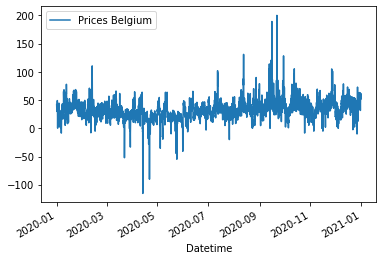

In [249]:
cols = ['Datetime', 'Prices Belgium']
plot_price = test_data[cols].drop_duplicates()
plot_price.plot('Datetime', 'Prices Belgium')

In [250]:
def cutting_outbreaks(df):
    pass

In [251]:
def data_aggregation(df, save_datetime = False, test=False):
    result = []

    if not test:
        df['Datetime'] = train_data.dropna(axis=0)['Datetime']
    else:
        df['Datetime'] = test_data.dropna(axis=0)['Datetime']

    cols_a = ['Datetime', 'Total Load', 'Total installed power','Day-ahead Price [EUR/MWh]', 
                'hr_sin', 'hr_cos', 'day_sin', 'day_cos', 'mnth_sin', 'mnth_cos']
    a = df[cols_a].drop_duplicates()

    cols_b = ['Installed Power', 'Day Ahead Generation Schedule', 'Datetime']
    if not test:
        b = df[cols_b].groupby(['Datetime']).sum().reset_index()
    else:
        b = df[cols_b].groupby(['Datetime']).sum().reset_index()


    df_aggregated = pd.merge(a, b, on= 'Datetime')

    if not save_datetime:
        df_aggregated.drop(['Datetime'], axis = 1, inplace = True)

    return df_aggregated

In [252]:
def to_list_of_tensors_old(df, train_data, test_data, aggregation = False, test=False):
    if aggregation == False:
        result = []
        for value in train_data_normalized['Day-ahead Price [EUR/MWh]'].unique():
            list_for_one_price = []
            for index, row in train_data_normalized.loc[train_data_normalized['Day-ahead Price [EUR/MWh]'] == value].iterrows():
                list_for_one_price.append(row.values)
            result.append(torch.from_numpy(np.array(list_for_one_price)))

    if aggregation == True:
        result = []
        if not test:
            df['Datetime'] = train_data.dropna(axis=0)['Datetime']
        else:
            df['Datetime'] = test_data.dropna(axis=0)['Datetime']

        cols_a = ['Datetime', 'Total Load', 'Total installed power','Day-ahead Price [EUR/MWh]', 
                    'hr_sin', 'hr_cos', 'day_sin', 'day_cos', 'mnth_sin', 'mnth_cos']
        a = df[cols_a].drop_duplicates()

        cols_b = ['Installed Power', 'Day Ahead Generation Schedule', 'Datetime']
        b = df[cols_b].groupby(['Datetime']).sum().reset_index()

        df_aggregated = pd.merge(a, b, on= 'Datetime').drop(['Datetime'], axis = 1)

        for index, row in df_aggregated.iterrows():
            result.append(torch.from_numpy(row.values))

    return result

In [253]:
def to_list_of_tensors(df):
    result = []

    if 'Datetime' in df.columns:
        df.drop('Datetime', axis = 1, inplace = True)

    for index, row in df.iterrows():
        result.append(torch.from_numpy(row.values))

    return result

In [254]:
def final_function():
    #first thing is to load all the data from the csv
    train_data, test_data = data_loading()

    #then we want to have the data to be normalized with datetime ecnoded
    train_data_normalized = encoding_datetime(data_normalization(train_data, add_timestamp=True))
    test_data_normalized = encoding_datetime(data_normalization(test_data, add_timestamp=True, test=True))

    #Now we have two normalized datasets with encoded datetime
    #We want to return aggregated versions of them as lists of tensors

    train_tensor_list = to_list_of_tensors(train_data_normalized)
    test_tensor_list = to_list_of_tensors(test_data_normalized)

    #we also want to have lists of features and target seprately for both train and test
    target_train, features_train = target_column_as_list(train_data_normalized)
    target_test, features_test = target_column_as_list(test_data_normalized)

    #target_train, features_train = target_column_as_list(data_aggregation(train_data_normalized, save_datetime=True))
    #target_test, features_test = target_column_as_list(data_aggregation(test_data_normalized, save_datetime=True, test=True))

    return {'train_data': train_data,
            'test_data' : test_data,
            'train_data_normalized': train_data_normalized,
            'test_data_normalized' : test_data_normalized,
            'train_tensor_list' : train_tensor_list,
            'test_tensor_list' : test_tensor_list,
            'target_train_tensor_list' : target_train,
            'features_train_tensor_list' : features_train,
            'target_test_tensor_list' : target_test,
            'features_test_tensor_list' : features_test}



In [255]:
data_dict = final_function()

## Network

In [256]:
feature_cols = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE']

X_train = data_dict['train_data_normalized'][feature_cols]
y_train = data_dict['train_data_normalized']['Prices Belgium']

X_test = data_dict['test_data_normalized'][feature_cols]
y_test = data_dict['test_data_normalized']['Prices Belgium']

In [257]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (43897, 15) (43897,)
Testing Shape (43897, 15) (43897,)


In [258]:
y_train.to_numpy()

array([0.05252723, 0.05252723, 0.05252723, ..., 0.06609005, 0.06063044,
       0.05709606])

In [259]:
X_train_tensors = Variable(torch.Tensor(X_train.to_numpy()))
X_test_tensors = Variable(torch.Tensor(X_test.to_numpy()))

y_train_tensors = Variable(torch.Tensor(y_train.to_numpy()))
y_train_tensors = y_train_tensors.unsqueeze(1)
y_test_tensors = Variable(torch.Tensor(y_test.to_numpy())) 
y_test_tensors = y_test_tensors.unsqueeze(1)

In [260]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [261]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([43897, 1, 15]) torch.Size([43897, 1])
Testing Shape torch.Size([43897, 1, 15]) torch.Size([43897, 1])


In [262]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.rand(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.rand(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for the next layer
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        return out

In [263]:
num_epochs = 3000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = len(feature_cols) #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [264]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.00117
Epoch: 100, loss: 0.00094
Epoch: 200, loss: 0.00083
Epoch: 300, loss: 0.00068
Epoch: 400, loss: 0.00055
Epoch: 500, loss: 0.00051
Epoch: 600, loss: 0.00049
Epoch: 700, loss: 0.00047
Epoch: 800, loss: 0.00046
Epoch: 900, loss: 0.00045
Epoch: 1000, loss: 0.00044
Epoch: 1100, loss: 0.00044
Epoch: 1200, loss: 0.00044
Epoch: 1300, loss: 0.00043
Epoch: 1400, loss: 0.00042
Epoch: 1500, loss: 0.00042
Epoch: 1600, loss: 0.00042
Epoch: 1700, loss: 0.00042
Epoch: 1800, loss: 0.00041
Epoch: 1900, loss: 0.00041
Epoch: 2000, loss: 0.00041
Epoch: 2100, loss: 0.00041
Epoch: 2200, loss: 0.00041
Epoch: 2300, loss: 0.00040
Epoch: 2400, loss: 0.00040
Epoch: 2500, loss: 0.00040
Epoch: 2600, loss: 0.00040
Epoch: 2700, loss: 0.00040
Epoch: 2800, loss: 0.00039
Epoch: 2900, loss: 0.00039


In [265]:
transformer = preprocessing.MaxAbsScaler()
df = pd.concat([data_dict['train_data'], data_dict['test_data']], ignore_index=True)
df_X = transformer.fit(df[feature_cols])
df_X = transformer.transform(df[feature_cols])
df_y = transformer.fit(df['Prices Belgium'].to_numpy().reshape(-1,1))
df_y = transformer.transform(df['Prices Belgium'].to_numpy().reshape(-1,1))

In [266]:
df_X = Variable(torch.Tensor(df_X)) #converting to Tensors
df_y = Variable(torch.Tensor(df_y))

df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1])) 

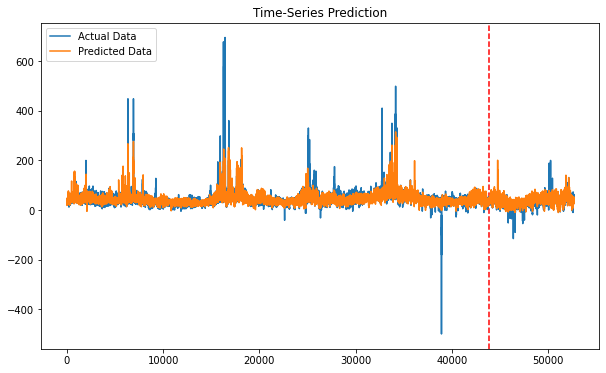

In [267]:
train_predict = model(df_X)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = transformer.inverse_transform(data_predict) #reverse transformation
dataY_plot = transformer.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=len(X_train), c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [268]:
transformer = preprocessing.MaxAbsScaler()
#df = pd.concat([data_dict['train_data'], data_dict['test_data']], ignore_index=True)
df = X_test
df_X = transformer.fit(df[feature_cols])
df_X = transformer.transform(df[feature_cols])
df_y = transformer.fit(y_test.to_numpy().reshape(-1,1))
df_y = transformer.transform(y_test.to_numpy().reshape(-1,1))

In [269]:
df_X = Variable(torch.Tensor(df_X)) #converting to Tensors
df_y = Variable(torch.Tensor(df_y))

df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1])) 

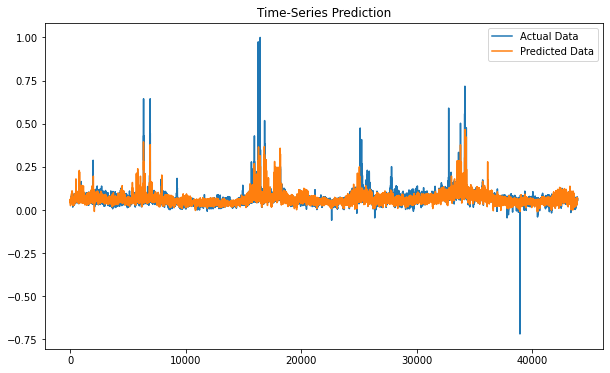

In [270]:
train_predict = model(df_X)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = transformer.inverse_transform(data_predict) #reverse transformation
dataY_plot = transformer.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
#plt.axvline(x=len(X_train), c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

## Arima Model

In [271]:
model = ARIMA(data_dict['train_data_normalized']['Prices Belgium'].to_numpy(), 
            data_dict['train_data_normalized'][feature_cols].to_numpy(), order = (1,1,2))

model_fit = model.fit()
print(model_fit.summary())

/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                43897
Model:                 ARIMA(1, 1, 2)   Log Likelihood              124304.719
Date:                Fri, 28 Jan 2022   AIC                        -248571.438
Time:                        01:16:51   BIC                        -248406.336
Sample:                             0   HQIC                       -248519.405
                              - 43897                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0031      0

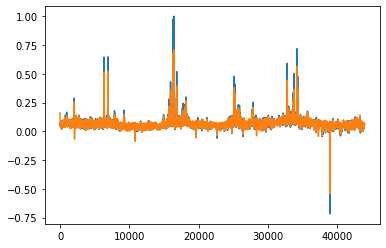

In [272]:
plt.figure(figsize=(10,6))
plt.plot(data_dict['train_data_normalized'].index, data_dict['train_data_normalized']['Prices Belgium'])
plt.plot(data_dict['train_data_normalized'].index, model_fit.predict())

plt.show()

In [278]:
values = []
for index, row in data_dict['test_data_normalized'][feature_cols].iterrows():
    values = model_fit.forecast(exog = row.values)

plt.plot(data_dict['test_data_normalized'].index, data_dict['test_data_normalized']['Prices Belgium'])
plt.plot(data_dict['test_data_normalized'].index, values)

plt.show()

In [227]:
data_dict['train_data_normalized']

,index,Prices France,Prices Belgium,Biomass - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],...,Wind Onshore - Actual Aggregated [MW],Day-ahead Total Load Forecast [MW] - CTA|BE,Actual Total Load [MW] - CTA|BE,year,hr_sin,hr_cos,day_sin,day_cos,mnth_sin,mnth_cos
0,0,0.041830,0.052527,0.168734,0.469804,0.925532,0.0,0.289292,0.000000,0.750000,...,0.104056,0.702574,0.730930,2015,0.000000,1.000000e+00,0.000000,1.000000,0.0,1.000000
1,1,0.041830,0.052527,0.171216,0.464802,0.923404,0.0,0.132124,0.000000,0.750000,...,0.120517,0.739961,0.698744,2015,0.258819,9.659258e-01,0.000000,1.000000,0.0,1.000000
2,2,0.041830,0.052527,0.171216,0.456280,0.925532,0.0,0.228843,0.005819,0.750000,...,0.126984,0.707684,0.669465,2015,0.500000,8.660254e-01,0.000000,1.000000,0.0,1.000000
3,3,0.041830,0.052527,0.168734,0.415524,0.927660,0.0,0.228843,0.007481,0.750000,...,0.139330,0.678974,0.643624,2015,0.707107,7.071068e-01,0.000000,1.000000,0.0,1.000000
4,4,0.041830,0.052527,0.166253,0.395332,0.927660,0.0,0.228843,0.343308,0.770833,...,0.191652,0.662195,0.626689,2015,0.866025,5.000000e-01,0.000000,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43892,43892,0.052700,0.066176,0.898263,0.405335,0.000000,0.0,0.244387,0.000831,0.645833,...,0.090535,0.807990,0.759386,2019,-0.965926,-2.588190e-01,0.974928,-0.222521,-0.5,0.866025
43893,43893,0.054610,0.068576,0.903226,0.408114,0.000000,0.0,0.308290,0.000831,0.645833,...,0.139918,0.805872,0.735447,2019,-1.000000,-1.836970e-16,0.974928,-0.222521,-0.5,0.866025
43894,43894,0.052631,0.066090,0.905707,0.391627,0.000000,0.0,0.280656,0.000831,0.645833,...,0.217519,0.777794,0.705144,2019,-0.965926,2.588190e-01,0.974928,-0.222521,-0.5,0.866025
43895,43895,0.048283,0.060630,0.900744,0.372175,0.000000,0.0,0.025043,0.000831,0.645833,...,0.256320,0.738456,0.685320,2019,-0.866025,5.000000e-01,0.974928,-0.222521,-0.5,0.866025


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ca6f955c-b181-41cc-a47f-43205351cbaf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>